# Ideas

- Prompt any image for ships by putting a patch along it with point annotation
- Prompt images for text (didn't work well)
- Pass through YOLO to generate a single point or bbox annotation for ships and then through SAM to get the rest
- Orient the xView ship dataset by prompting with the ground-truth labels and converting the masks to oriented bboxes.


In [1]:
# Autoreload changes from source
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy as np
from ultralytics.utils.instance import Bboxes
from PIL import Image
from ultralytics import YOLO
from ultralytics import SAM
import numpy as np 


In [2]:
model = SAM('sam_b.pt')
# Display model information (optional)
model.info()

Model summary: 238 layers, 93735472 parameters, 93735472 gradients


(238, 93735472, 93735472, 0.0)

In [3]:
from PIL import Image

class Points:
    def __init__(self, points: list[list[int]], normalized):
        "Accepts a list of list of xyxy points and a boolean normalized flag"
        self.points = points
        self.normalized = normalized
    def denormalize(self, w,h):
        # self.points is a list of list
        " Denormalize the points"
        if self.normalized:
            self.points = [[int(x * w), int(y * h)] for x, y in self.points]
            self.normalized = False
    def normalize(self, w, h):
        if not self.normalized:
            self.points = [[x / w, y / h] for x, y in self.points]
            self.normalized = True

def get_point_prompts(lb_path, normalized):
    "Accepts lb_path containing labels, each labels is a line with xyxy box coordinates"
    # Read the file
    with open(lb_path, "r") as file:
        lines = file.readlines()
    # Parse the lines
    points = []
    labels = []
    for line in lines:
        components = line.split()
        class_idx = int(components[0])
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, components[1:])
    # Calculate the center of the box
        center_x = (x1 + x2 + x3 + x4) / 4
        center_y = (y1 + y2 + y3 + y4) / 4
        
        points.append([center_x, center_y])
        labels.append(class_idx)
    return Points(points, normalized), labels

In [4]:

import cv2
import numpy as np
import torch

def get_enclosing_points(mask: torch.Tensor) -> np.ndarray:
    "Accepts a mask tensor HW of type bool, and returns the 4 points of the enclosing rectangle as nd.array"
    # Convert the mask to a numpy array if it's a PyTorch tensor
    if isinstance(mask, torch.Tensor):
         mask = (mask.cpu().numpy() * 255).astype(np.uint8)

    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the contour with the maximum area (in case there are multiple contours)
    max_contour = max(contours, key=cv2.contourArea)

    # Get a rotated rectangle that encloses the contour
    rect = cv2.minAreaRect(max_contour)

    # Get the 4 points of the rectangle
    points = cv2.boxPoints(rect)

    return points.reshape(1,-1)


In [5]:

def xyxyxyxy_to_xyxy(box: list)-> list:
    " Convert 1x8 bbox list from xyxyxyxy to xyxy list"
    x1, y1, x2, y2, x3, y3, x4, y4 = box
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    y = [x_min, y_min, x_max, y_max]
    return y

def get_box_prompts(lb_path) -> tuple[Bboxes, list]:
    " Get the boxes and labels from the label file, label is in the YOLO DET format,i.e bottom left, top right: class_idx, x1, y1, x2, y2"
    with open(lb_path, "r") as file:
        lines = file.readlines()
    # Open the image
    
    # Parse the lines
    boxes = []
    labels = []
    for line in lines:
        components = line.split()
        class_idx = int(components[0])
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, components[1:])
        boxes.append([x1, y1, x2, y2, x3, y3, x4, y4])
        labels.append(class_idx)
    xyxy_boxes = list(map(xyxyxyxy_to_xyxy, boxes))
    bboxes = Bboxes(
        bboxes=np.array(xyxy_boxes),
        format="xyxy",
    )	
    return bboxes, labels

def write_bboxes_to_file(bboxes: np.ndarray, labels: list, path: str, format: str = "xyxy"):
    " Write the bboxes and labels to a file, bboxes is a N,X array depending on the format, labels is a list of class indices, path is the output file path to save the labels"
    assert len(bboxes) == len(labels), "The number of bboxes and labels must be the same"
    with open(path, "w") as file:
        for box, label in zip(bboxes, labels):
            match format:
                case "xyxy":
                    assert len(box) == 4, "The box must be in the format x1, y1, x2, y2"
                case "xywh":
                    assert len(box) == 4, "The box must be in the format x, y, w, h"
                case "xyxyxyxy":
                    assert len(box) == 8, "The box must be in the format x1, y1, x2, y2, x3, y3, x4, y4"
                case "xywhr":
                    assert len(box) == 5, "The box must be in the format x, y, w, h, r"
            formatted_coords = ["{:.6f}".format(float(coord)) for coord in box]
            file.write(f"{int(label)} {' '.join(formatted_coords)}\n")

def get_img_size(img_path: str) -> tuple[int, int]:
    img = Image.open(img_path)
    return img.size



In [6]:

lb_path = "./datasets/xView-patches/labels/train/1351__682__698___1396.txt"
#lb_path = "./datasets/xView-patches/labels/val/92__1024__0___524.txt"
img_path = lb_path.replace("labels", "images").replace("txt", "jpg")
# Read the file
points, labels = get_point_prompts(lb_path=lb_path, normalized=True)
xyxyboxes, labels = get_box_prompts(lb_path)
from ultralytics.utils.instance import Instances
w,h = get_img_size(img_path)
points.denormalize(w=w, h=h)
instances = Instances(bboxes=xyxyboxes.bboxes, bbox_format="xyxy", normalized=True)
instances.denormalize(w=w, h=h)
res=model(img_path, bboxes=instances.bboxes, points=points.points, labels=labels)

for r in res:
    im_array = r.plot(save=True, filename='results.jpg')  # plot a BGR numpy array of predictions

r = res[0]
# Open the image
image = Image.open('results.jpg')
image



image 1/1 /work3/dimda/ultralytics_dotav2/examples/datasets/xView-patches/images/train/1351__682__698___1396.jpg: 1024x1024 1606.2ms
Speed: 6.4ms preprocess, 1606.2ms inference, 0.2ms postprocess per image at shape (1, 3, 1024, 1024)


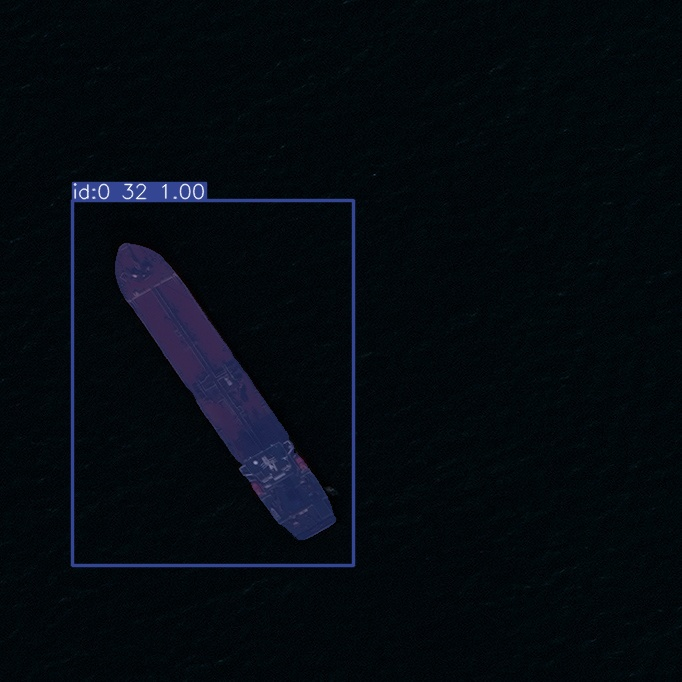

In [7]:
mask = r.masks.data[0]
from ultralytics.utils.ops import xyxyxyxy2xywhr
CLASS_NAMES = {i: str(i) for i in range(1, 61)}
obb_boxes = np.vstack([get_enclosing_points(mask) for mask in r.masks.data])
obb_labels = np.hstack((np.array([labels]).T, obb_boxes))
obb_boxes_xywhr = xyxyxyxy2xywhr(obb_boxes)
lb = np.array([labels]).T
r.names = CLASS_NAMES
obb_labels_xywhrclass = np.hstack((obb_boxes_xywhr, np.zeros_like(lb), np.ones_like(lb), lb)) # [xywh, rotation,] track_id, conf, cls
original_labels = np.hstack((xyxyboxes.bboxes, np.zeros_like(lb), np.ones_like(lb), lb))
r.update(boxes=original_labels) 

for r in res:
    im_array = r.plot(save=True, filename='results.jpg')  # plot a BGR numpy array of predictions

r.update(boxes=original_labels,obb=obb_labels_xywhrclass)
for r in res:
    im_array = r.plot(save=True, filename='results+obb.jpg')  # plot a BGR numpy array of predictions

# Open the image
image = Image.open('results.jpg')
image


In [35]:
from ultralytics.utils.instance import Instances
from ultralytics.utils.ops import xyxyxyxy2xywhr
from ultralytics.data.split_dota import load_yolo_dota
from tqdm import tqdm
from pathlib import Path
import yaml

def check_if_inside(point, box):
    x, y = point
    x1, y1, x2, y2 = box
    return x >= x1 and x <= x2 and y >= y1 and y <= y2
                
def associate_points_to_boxes(points,boxes, og_labels, no_match_class):
                " Associate boxes to first matching OG label"
                labels_ = []
                for box in boxes:
                    for i,point in enumerate(points):
                        if check_if_inside(point, box):
                            labels_.append(og_labels[i])
                            break
                    else:
                        labels_.append(no_match_class)
                return labels_
class DatasetOBBExtractor:
    def __init__(self, model, dataset_dir, output_dir, default_class, debug=False):
        self.model = model
        self.dataset_dir = dataset_dir
        self.output_dir = output_dir
        #Read classes names from ultralytics/cfg/datasets/xView-patches.yaml
        yaml_path = Path("../ultralytics/cfg/datasets/xView-patches.yaml")
        self.default_class = default_class
        self.debug = debug
        with open(yaml_path, "r") as file:
            self.CLASS_NAMES = yaml.safe_load(file)["names"]
            self.IDX_NAMES = {v: k for k, v in self.CLASS_NAMES.items()}

        assert self.default_class in self.IDX_NAMES.keys(), f"The default class {self.default_class} is not in the class names"

        # Create output dirs
        (Path(output_dir) / Path('labels') / Path('train') ).mkdir(parents=True, exist_ok=True)
        (Path(output_dir) / Path('labels') / Path('val') ).mkdir(parents=True, exist_ok=True)
        if self.debug:
            (Path(output_dir) / Path('debug') / Path('train') ).mkdir(parents=True, exist_ok=True)
            (Path(output_dir) / Path('debug') / Path('val') ).mkdir(parents=True, exist_ok=True)
        # Check if dataset_dir exists
        assert Path(dataset_dir).exists(), f"The dataset_dir {dataset_dir} does not exist"
    def get_dataset_info(self):
        " Get the dataset information"
        
        self.data_info = load_yolo_dota(self.dataset_dir)
        # Filter list based on len(data["label"]) > 0
        self.data_info = list(filter(lambda x: len(x["label"]) > 0, self.data_info))
    def process(self, idxs=None):
        dataset = self.data_info
        if idxs:
            # Grab only indexes of interest (might be not useful because empty labels)
            dataset = [dataset[i] for i in idxs]
        for data in tqdm(dataset):
            lb_path = data["filepath"].replace("images", "labels").replace("jpg", "txt")
            points, labels = get_point_prompts(lb_path=lb_path, normalized=True)
            xyxyboxes, labels = get_box_prompts(lb_path)
            labels_arr = np.array(labels)
            # Keep only ship points
            labels_reduced = [label for label in labels if label >= 23 and label <= 32] # Hard coded ship classes
            points.points = [point for point, label in zip(points.points, labels) if label >= 23 and label <= 32] # Hard coded ship classes
            # Keep only ship boxes, ie  label <= 23 <=32
            xyxyboxes.bboxes = xyxyboxes.bboxes[np.where((labels_arr >= 23) & (labels_arr <= 32))]

            # If no objects of interest in this image, skip.
            if len(labels_reduced) < 1:
                continue

            w,h = data["ori_size"]
            # Px coordinates of point queries
            points.denormalize(w=w, h=h)
            # Normalized box queries
            instances = Instances(bboxes=xyxyboxes.bboxes, bbox_format="xyxy", normalized=True)
            # Px box queries
            instances.denormalize(w=w, h=h)
            # Probe SAM
            res=model(data["filepath"], bboxes=instances.bboxes, points=points.points, labels=labels)
            # Assert the length of results is 1
            assert len(res) == 1, "The model should return only one result"
            r = res[0]

            # Get boxes from masks XXX: Some masks are sometimes disjoint even though they correspond to the same object.
            obb_boxes = np.vstack([get_enclosing_points(mask) for mask in r.masks.data])
            # Get original label path 
            lb_relative_path = Path(data["filepath"]).relative_to(Path(data["filepath"]).parents[2])
            lb_abs_path = Path(self.output_dir) / lb_relative_path
            # New label path
            output_label = str(lb_abs_path.with_suffix('.txt')).replace("images", "labels")
            
            # Transfer old label classes to obb boxes by association.
            labels_ = associate_points_to_boxes(points.points, xyxyboxes.bboxes, labels_reduced, self.IDX_NAMES[self.default_class])
            # Write label file
            write_bboxes_to_file(obb_boxes, labels_, output_label, format="xyxyxyxy")
            # If debug save images with OG and new labels, return generator object.
            if self.debug:
                og_det_path, obb_det_path = self.plot(r, instances.bboxes, obb_boxes, labels_, output_label)
                yield  og_det_path, obb_det_path

    def plot(self,res, axes_boxes, obb_boxes, labels, output_label):
        obb_boxes_xywhr = xyxyxyxy2xywhr(obb_boxes)
        lb = np.array([labels]).T
        res.names = self.CLASS_NAMES
        obb_labels_xywhrclass = np.hstack((obb_boxes_xywhr, np.zeros_like(lb), np.ones_like(lb), lb)) # [xywh, rotation,] track_id, conf, cls
        xyxy_labels = np.hstack((axes_boxes, np.zeros_like(lb), np.ones_like(lb), lb ))
        res.update(boxes=xyxy_labels)

        og_det_path = str(Path(output_label).with_suffix(".jpg")).replace("labels","debug")
        obb_det_path = str(Path(output_label).with_suffix(".obb.jpg")).replace("labels","debug")
        res.plot(save=True, filename=og_det_path)  # plot a BGR numpy array of predictions
        res.update(obb=obb_labels_xywhrclass)
        res.plot(save=True, filename=obb_det_path)  # plot a BGR numpy array of predictions
        return og_det_path, obb_det_path

dat = DatasetOBBExtractor(model, "./datasets/xView-patches", "./datasets/xView-sam-patches", "Maritime Vessel", True)
dat.get_dataset_info()
processor_generator = dat.process(idxs=None)
results = list(processor_generator)

Loading image metadata:   5%|▌         | 4245/82138 [03:55<1:11:57, 18.04it/s]


KeyboardInterrupt: 

: 

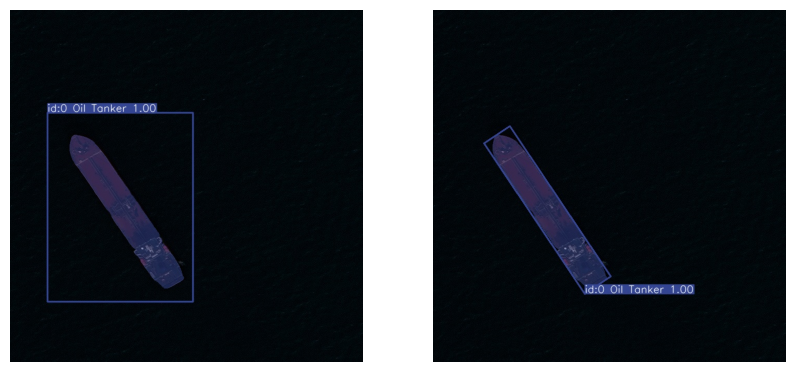

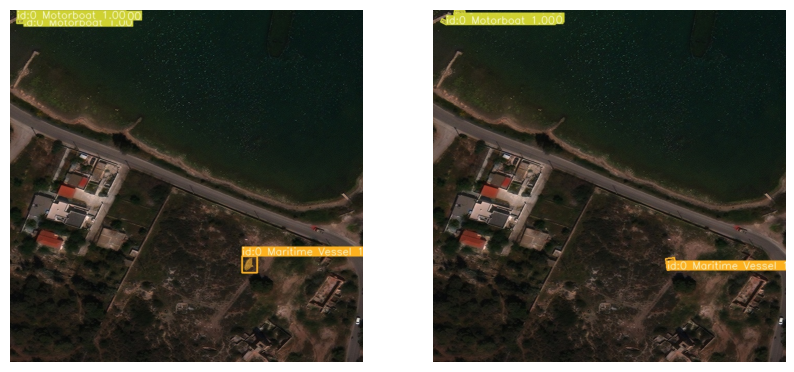

In [34]:

# Randomly select 10 results
import random

import matplotlib.pyplot as plt

for result in random.sample(results, 5):
    og_path, obb_path = result
    img1 = Image.open(og_path)
    img2 = Image.open(obb_path)


    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Display the first image in the left subplot
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')  # Hide axes

    # Display the second image in the right subplot
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')  # Hide axes

    # Show the figure
    plt.show()

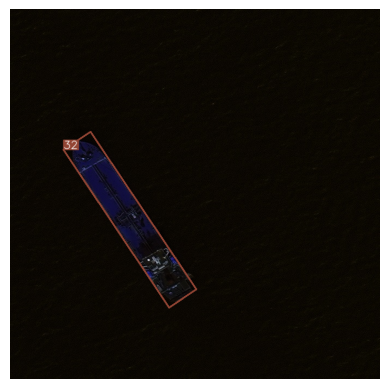

In [9]:
import cv2 as cv
import numpy as np
from ultralytics.utils.plotting import Annotator, colors

obb_names = CLASS_NAMES
obb_image = cv.imread(img_path)

ann = Annotator(
    obb_image,
    line_width=None,  # default auto-size
    font_size=None,   # default auto-size
    font="Arial.ttf", # must be ImageFont compatible
    pil=False,        # use PIL, otherwise uses OpenCV
)
for obb in obb_labels:
    c_idx, *obb = obb
    obb = np.array(obb).reshape(-1, 4, 2).squeeze()
    label = CLASS_NAMES[c_idx]
    ann.box_label(
        obb,
        label,
        color=colors(c_idx, True),
        rotated=True,
    )

image_with_obb = ann.result()
import matplotlib.pyplot as plt

plt.imshow(image_with_obb)
plt.axis('off')
plt.show()
